In [2]:
!pip install langchain_google_genai
!pip install numexpr
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.6 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 15.2 MB/s eta 0:00:00


In [ ]:
# agent.py
import json
from typing import TypedDict, Annotated, Sequence
import re
import numexpr
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import BaseMessage, ToolMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode


In [ ]:
# Knowlwdgebase

In [81]:
KB = {
    "DOC-1": {
        "title": "LLUMO AI – Core Value",
        "text": "LLUMO AI is an evaluation-first reliability layer for LLM apps. It focuses on automated scoring, actionable insights, and cost savings via prompt compression—helping teams ship trustworthy AI."
    },
    "DOC-2": {
        "title": "LLUMO AI – Debugger",
        "text": "LLUMO’s Debugger shows run-level logs, stepwise tool traces, and a flow graph to isolate failure points such as tool selection errors or context mismatch."
    },
    "DOC-3": {
        "title": "Company Policy – Working Hours",
        "text": "Standard working hours are 10:00 to 18:30 IST, Monday to Friday. Flexible timings are allowed with manager approval."
    },
    "DOC-4": {
        "title": "Finance FAQ – Reimbursements",
        "text": "Submit reimbursements within 30 days. Keep original receipts. Typical settlement time is 7 business days after approval."
    },
    "DOC-5": {
        "title": "Math Snippets",
        "text": "Examples: (125 * 6) - 50 = 700; 15% of 640 = 96; Average of [10, 20, 30, 40] = 25."
    }
}

In [ ]:
# --- Tool Implementations ---

In [ ]:

@tool
def retriever(query: str, k: int = 1) -> list[str]:
    """
    Loads the Knowledge Base and returns the top-K passages that are most relevant to the query.
    This is a general-purpose tool for finding information.
    """
    query_words = set(query.lower().split())
    scores = {}
    for doc_id, content in KB.items():
        doc_words = set(content['title'].lower().split()) | set(content['text'].lower().split())
        score = len(query_words.intersection(doc_words))
        if score > 0:
            scores[doc_id] = score
    sorted_docs = sorted(scores.items(), key=lambda item: item[1], reverse=True)
    return [KB[doc_id]['text'] for doc_id, _ in sorted_docs[:k]]

@tool
def policy_lookup(query: str) -> str:
    """
    A specialized tool to look up information specifically from policy or FAQ documents.
    This is a shortcut to the retriever for common internal queries.
    """
    query_words = set(query.lower().split())

    policy_docs = {
        doc_id: content for doc_id, content in KB.items()
        if "policy" in content['title'].lower() or "faq" in content['title'].lower()
    }

    scores = {}
    for doc_id, content in policy_docs.items():
        doc_words = set(content['title'].lower().split()) | set(content['text'].lower().split())
        score = len(query_words.intersection(doc_words))
        if score > 0:
            scores[doc_id] = score

    if not scores:
        return "No specific policy or FAQ document found that matches the query."

    best_doc_id = max(scores, key=scores.get)
    return KB[best_doc_id]['text']

@tool
def calculator(expression: str) -> str:
    """
    Performs arithmetic calculations safely.
    It can handle standard mathematical operations.
    For percentages, please convert them to decimals (e.g., 15% of 640 should be input as '0.15 * 640').
    """
    try:
        result = numexpr.evaluate(expression).item()
        return f"The result of the expression '{expression}' is: {result}"
    except Exception as e:
        return f"Error: Could not evaluate the expression. Details: {e}"

@tool
def string_tools(text: str, extract: str) -> list[str]:
    """
    A utility tool to extract specific patterns from a given text.
    'extract' can be 'numbers' or 'percentages'.
    """
    if extract.lower() == "numbers":
        return re.findall(r'\d+\.\d+|\d+', text)
    elif extract.lower() == "percentages":
        return re.findall(r'\d+\s*%', text)
    else:
        return ["Error: Invalid 'extract' parameter. Please use 'numbers' or 'percentages'."]

# A list containing all the tools that the agent can use.
all_tools = [retriever, policy_lookup, calculator, string_tools]

In [85]:
# --- 1. Define Agent State ---
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], lambda x, y: x + y]

In [86]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant designed to answer user queries. You MUST use the tools provided to find the information. Do not apologize or say you cannot access information. Use the tools to get the answer.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


In [ ]:
# model use gemini api 2.0-flash

In [ ]:
api_key = ""

In [89]:
model = ChatGoogleGenerativeAI(temperature=0.3, model="gemini-2.0-flash",api_key=api_key)

In [90]:
model = model.bind_tools(all_tools)

In [ ]:
# Creating chain 

In [91]:
agent_runnable = prompt | model

In [ ]:
def should_continue(state: AgentState) -> str:
    """
    This is a conditional edge. It determines whether the agent should continue calling tools
    or if it's ready to generate the final response.
    """
    last_message = state['messages'][-1]
    if not last_message.tool_calls:
        return "end"
    return "continue"

def call_model(state: AgentState):
    """
    This node is responsible for calling the language model.
    """
    response = agent_runnable.invoke(state)
    return {"messages": [response]}

In [ ]:
# --- 4. Build the Graph ---
workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", ToolNode(all_tools))

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END,
    },
)

workflow.add_edge("action", "agent")

app = workflow.compile()

In [ ]:
# ----Workflow------

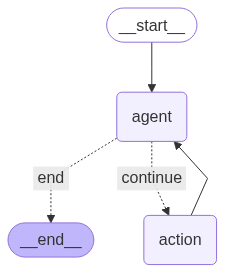

In [93]:
app

In [ ]:
# --- 5. Run the Agent Interactively ---

In [ ]:
if __name__ == "__main__":
    # --- MODIFIED: Switched to an interactive loop instead of a fixed list ---
    while True:
        query = input("Enter your query (or type 'exit' to quit): ")
        if query.lower() in ["exit", "quit"]:
            break

        print(f"\n--- Running Query: {query} ---")

        inputs = {"messages": [HumanMessage(content=query)]}

        query_log = []

        for output in app.stream(inputs, stream_mode="values"):
            step_messages = output['messages']
            query_log.append(step_messages)
            print(f"Step Output: {step_messages}\n")

        final_answer = query_log[-1][-1].content
        print(f"\nFinal Answer: {final_answer}\n")

        # --- MODIFIED: Append logs to the file instead of overwriting ---
        try:
            with open("logs.json", "r+") as f:
                all_logs = json.load(f)
        except (FileNotFoundError, json.JSONDecodeError):
            all_logs = {}

        all_logs[query] = query_log

        with open("logs.json", "w") as f:
            def custom_serializer(o):
                if hasattr(o, '__dict__'):
                    return o.__dict__
                return str(o)
            json.dump(all_logs, f, indent=4, default=custom_serializer)

    print("\n--- Session ended. Logs saved to logs.json ---")


Enter your query (or type 'exit' to quit): LLUMO AI – Core Value

--- Running Query: LLUMO AI – Core Value ---
Step Output: [HumanMessage(content='LLUMO AI – Core Value', additional_kwargs={}, response_metadata={})]

Step Output: [HumanMessage(content='LLUMO AI – Core Value', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'function_call': {'name': 'policy_lookup', 'arguments': '{"query": "LLUMO AI core values"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--cf38a993-ca22-4506-8f5e-cef30780246d-0', tool_calls=[{'name': 'policy_lookup', 'args': {'query': 'LLUMO AI core values'}, 'id': '33a0ac17-41c2-4d45-a18b-6cde4a5783f2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 214, 'output_tokens': 10, 'total_tokens': 224, 'input_token_details': {'cache_read': 0}})]

Step Output: [HumanMessage(content='LLUMO AI – Core Val